In [1]:
%load_ext autoreload
%autoreload 2
from DiDi_utils import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
from datetime import datetime
%matplotlib inline

## Load GPS data

In [2]:
gps_region = load_data('DiDi\gps_20161002_in_region')
print(gps_region.shape)
gps_region.head(3)

(825727, 8)


## Define global variables
### Those variables are very useful to your implementation, please make sure you understand them

In [3]:
# global variables defined for the start time of the time intervals
global time_tuple
global time_tuple_plt
global g
time_tuple = range(1476288000, 1476288000 + 24*3600, 5*60)
time_tuple_plt = pd.to_datetime(list(time_tuple), unit='s') + pd.Timedelta(8, unit = 'h')
g = pyproj.Geod(ellps='WGS84')
print(time_tuple_plt)

DatetimeIndex(['2016-10-13 00:00:00', '2016-10-13 00:05:00',
               '2016-10-13 00:10:00', '2016-10-13 00:15:00',
               '2016-10-13 00:20:00', '2016-10-13 00:25:00',
               '2016-10-13 00:30:00', '2016-10-13 00:35:00',
               '2016-10-13 00:40:00', '2016-10-13 00:45:00',
               ...
               '2016-10-13 23:10:00', '2016-10-13 23:15:00',
               '2016-10-13 23:20:00', '2016-10-13 23:25:00',
               '2016-10-13 23:30:00', '2016-10-13 23:35:00',
               '2016-10-13 23:40:00', '2016-10-13 23:45:00',
               '2016-10-13 23:50:00', '2016-10-13 23:55:00'],
              dtype='datetime64[ns]', length=288, freq='5T')


In [4]:
#helper function
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = earth_radius * c
    return d

In [ ]:
calculate_distance(40.644718,-73.783279, 40.681320,-73.963799)

In [5]:
def dir():
    azN,azS,distance = g.inv(108.9415, 34.234, 108.943, 34.241)
    return azN, azS

## Speed Calculation

In [6]:
def calc_avg_speed(df):
    """
    TODO:
    Finish this function to calculate the northbound and 
    southbound average speeds for every 5-minute time interval along the day
    
    You can decied whatever you want as the input/output of the function
    """
    
    """
    Hint:
    """
    df_1 = df.copy()
    df_1 = df_1.sort_values('local_time').reset_index(drop = True)
    #direction angel
    azN,azS,distance = g.inv(108.9415, 34.234, 108.943, 34.241)
    
    northBound = pd.DataFrame(columns = ['avg_speed'])
    southBound = pd.DataFrame(columns = ['avg_speed'])
    
    df_1['direction'] = 'default'
    
    grouped = df_1.groupby('order_id')
    
    for order_id, group in grouped:
        rec = grouped.get_group(order_id).reset_index(drop = True)
        
        for i in range(len(rec)-1):
            az = g.inv(rec.wgs_lon.iloc[i], rec.wgs_lat.iloc[i],rec.wgs_lon.iloc[i+1], rec.wgs_lat.iloc[i+1])[0]
            if az == -180:
                rec.drop(rec.index[i+1])
            elif abs(az) <= azN:
                rec['direction'] = 'N'
            elif abs(az) >= abs(azS):
                rec['direction'] = 'S'
            else:
                rec.drop(rec.index[i+1])
        
        group_dir = rec.groupby('direction')
        
        i = 0
        for direction, group in group_dir:
            data = group_dir.get_group(direction).reset_index(drop = True)
            if(data['direction'][0] == 'N'):
                sum_speed = 0
                data['local_time1'] = data['local_time'].shift(1)
                data['lat1'] = data['wgs_lat'].shift(1)
                data['lon1'] = data['wgs_lon'].shift(1)

                time = (data.local_time - data.local_time1).dt.total_seconds()
                time = time.fillna(0)
                dis = calculate_distance(data.lat1,data.lon1,data.wgs_lat,data.wgs_lon)
                dis = dis.fillna(0)
                speed = dis/time*3.6
                speed = speed.fillna(0)
                avg_speed = np.sum(speed)/(len(rec)-1) if len(rec)!=1 else 0

                northBound.loc[len(northBound)] = [avg_speed]
                
            elif(data['direction'][0] == 'S'):
                sum_speed = 0
                data['local_time1'] = data['local_time'].shift(1)
                data['lat1'] = data['wgs_lat'].shift(1)
                data['lon1'] = data['wgs_lon'].shift(1)
                
                time = (data.local_time - data.local_time1).dt.total_seconds()
                time = time.fillna(0)
                dis = calculate_distance(data.lat1,data.lon1,data.wgs_lat,data.wgs_lon)
                dis = dis.fillna(0)
                speed = dis/time*3.6
                speed = speed.fillna(0)
                avg_speed = np.sum(speed)/(len(rec)-1) if len(rec)!=1 else 0

                southBound.loc[len(southBound)] = [avg_speed]

    north_avg = np.average(northBound.avg_speed) if len(northBound) != 0 else 0
    south_avg = np.sum(southBound.avg_speed)/len(southBound) if len(southBound) != 0 else 0
   
    return north_avg, south_avg 

In [7]:
def plot_avg_speed_profile(north, south):
    """
    TODO:
    plot the speed profile along the day
    
    You can decied whatever you want as the input/output of the function
    """
    fig = plt.figure(figsize = (15,6))
    plt.plot(north.start_time,
             north.average_speed,
             linestyle = '-',
             linewidth = 1,
             color = 'steelblue',
             marker = 'o',
             markersize = 5,
             markerfacecolor = 'steelblue')
    #fig.autofmt_xdate(rotation = 45)
    
    
    plt.title('north average speeds')
    plt.xlabel('time')
    plt.grid()
    plt.ylabel('average speed (km/h)')
    
    fig = plt.figure(figsize = (15,6))
    plt.plot(south.start_time,
             south.average_speed,
             linestyle = '-',
             linewidth = 1,
             color = 'steelblue',
             marker = 'o',
             markersize = 5,
             markerfacecolor = 'steelblue')
    
    plt.title('south average speeds')
    plt.xlabel('time')
    plt.grid()
    plt.ylabel('average speed (km/h)')

In [8]:
#select GPS points
area = gps_region.loc[(gps_region.wgs_lat > 34.234 ) & \
                    (gps_region.wgs_lat < 34.241 ) & \
                    (gps_region.wgs_lon > 108.9415 ) & \
                    (gps_region.wgs_lon < 108.943)].reset_index(drop = True)

north = pd.DataFrame(columns = ['start_time','stop_time','average_speed'])
south = pd.DataFrame(columns = ['start_time','stop_time','average_speed'])

df = area.sort_values('local_time').reset_index(drop = True)

for i in range(len(time_tuple_plt)):
    rec = df.loc[(df.local_time > time_tuple_plt[i]) & \
                         (df.local_time <= time_tuple_plt[i] + pd.Timedelta(minutes = 5))]
    
    speedN,speedS = calc_avg_speed(rec)
    north.loc[len(north)] = [time_tuple_plt[i],time_tuple_plt[i] + pd.Timedelta(minutes = 5), speedN]
    south.loc[len(south)] = [time_tuple_plt[i],time_tuple_plt[i] + pd.Timedelta(minutes = 5), speedS]

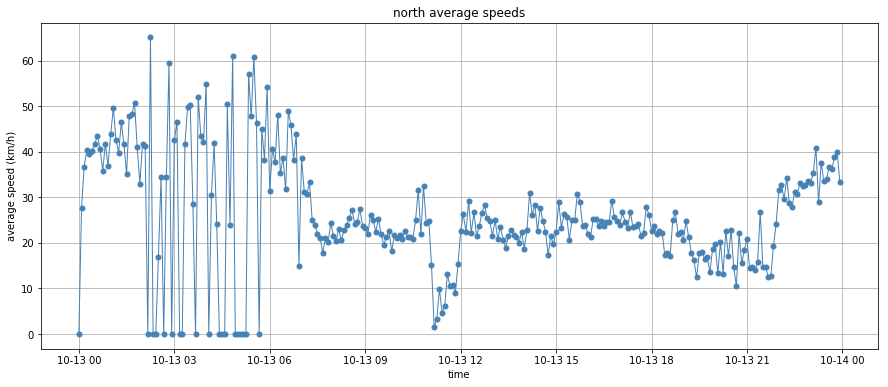

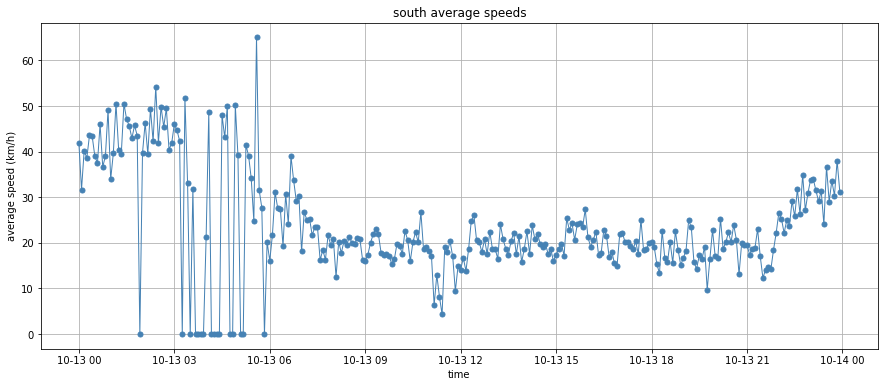

In [9]:
plot_avg_speed_profile(north, south)
#This is the wrong graph

In [10]:
#write to CSV file
north.to_csv("DiDi_north.csv",index = False) 
south.to_csv("DiDi_south.csv",index = False)